# setup


In [5]:
from sklearn.metrics import mean_squared_error

In [1]:
from toolbox.utils import *
from toolbox.utils.math import cumave
from toolbox.utils.utils import load_dict
from toolbox.io.lammps import LammpsData
from toolbox import plot

In [2]:
plot.use_style("pub-acs")

# PES

In [3]:
def find_data(dname, fname, dim=1):
    fnames = glob.glob(os.path.join(dname, "**", fname), recursive=True)
    fnames.sort()
    # print(fnames)
    all_data = []
    for fname in fnames:
        data = np.load(fname)
        all_data.append(data.reshape(-1, dim))
    all_data = np.concatenate(all_data, axis=0)
    return all_data

rmse [meV/atom]:  0.426448403317606
rmse [meV/atom]:  0.24889235706105087
rmse [meV/A]:  58.72890905939932
rmse [meV/A]:  51.80943611706065


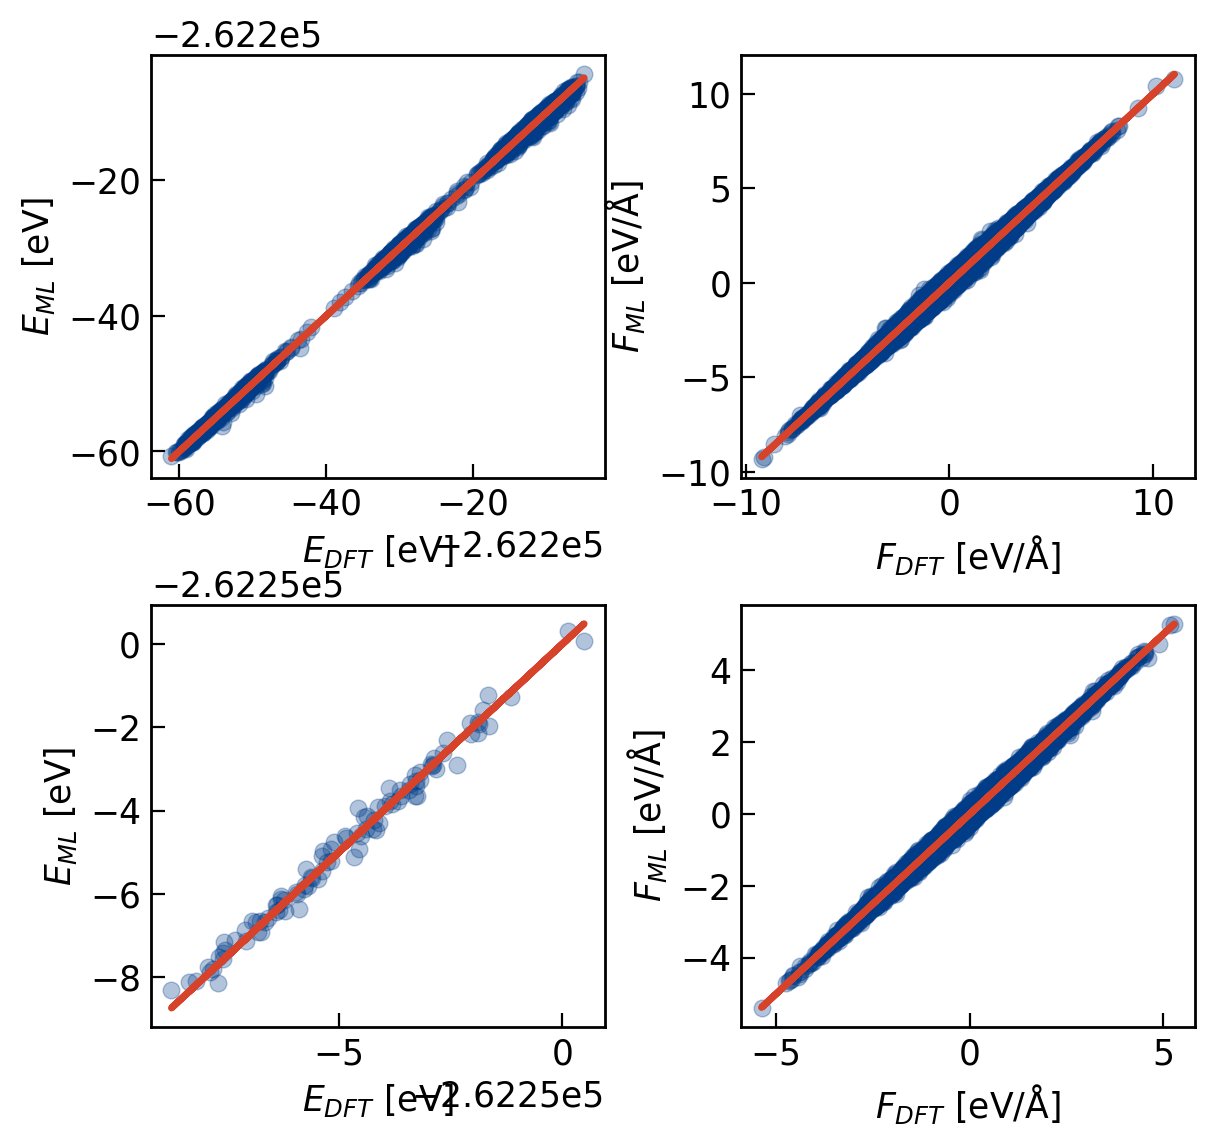

In [12]:
fig, axs = plt.subplots(2, 2, figsize=[6, 6])

fname = "energy.npy"
ax = axs[0][0]
dname = "data/pes/train"
dft_data = find_data(os.path.join(dname, "dft_data"), fname)
ml_data = find_data(os.path.join(dname, "ml_data"), fname)

ax.scatter(dft_data.flatten(), ml_data.flatten(), color="blue", alpha=0.3)
ax.plot(dft_data.flatten(), dft_data.flatten(), color="red")
plot.ax_setlabel(ax, "$E_{DFT}$ [eV]", "$E_{ML}$ [eV]")

rmse = np.sqrt(mean_squared_error(dft_data.flatten(), ml_data.flatten()))
print("rmse [meV/atom]: ", rmse / 906 * 1e3)

ax = axs[1][0]
dname = "data/pes/validation"
dft_data = find_data(os.path.join(dname, "dft_data"), fname)
ml_data = find_data(os.path.join(dname, "ml_data"), fname)

ax.scatter(dft_data.flatten(), ml_data.flatten(), color="blue", alpha=0.3)
ax.plot(dft_data.flatten(), dft_data.flatten(), color="red")
plot.ax_setlabel(ax, "$E_{DFT}$ [eV]", "$E_{ML}$ [eV]")

rmse = np.sqrt(mean_squared_error(dft_data.flatten(), ml_data.flatten()))
print("rmse [meV/atom]: ", rmse / 906 * 1e3)

fname = "force.npy"
ax = axs[0][1]
dname = "data/pes/train"
dft_data = find_data(os.path.join(dname, "dft_data"), fname, 3)
ml_data = find_data(os.path.join(dname, "ml_data"), fname, 3)

ax.scatter(dft_data.flatten(), ml_data.flatten(), color="blue", alpha=0.3)
ax.plot(dft_data.flatten(), dft_data.flatten(), color="red")
plot.ax_setlabel(ax, "$F_{DFT}$ [eV/Å]", "$F_{ML}$ [eV/Å]")

rmse = np.sqrt(mean_squared_error(dft_data.flatten(), ml_data.flatten()))
print("rmse [meV/A]: ", rmse * 1e3)

ax = axs[1][1]
dname = "data/pes/validation"
dft_data = find_data(os.path.join(dname, "dft_data"), fname, 3)
ml_data = find_data(os.path.join(dname, "ml_data"), fname, 3)

ax.scatter(dft_data.flatten(), ml_data.flatten(), color="blue", alpha=0.3)
ax.plot(dft_data.flatten(), dft_data.flatten(), color="red")
plot.ax_setlabel(ax, "$F_{DFT}$ [eV/Å]", "$F_{ML}$ [eV/Å]")

rmse = np.sqrt(mean_squared_error(dft_data.flatten(), ml_data.flatten()))
print("rmse [meV/A]: ", rmse * 1e3)

# fig.supxlabel(r"DFT data [meV/atom or meV/Å]", y=-0.05, fontsize="small")
# fig.supylabel("Probability [arb.u.]", x=-0.1, fontsize="small")
fig.subplots_adjust(hspace=0.3, wspace=0.3)

fig.savefig("plot/pes_validation.png")

plt.show()


## make topo


In [74]:
dname = "aimd_prl"
atoms = io.read(os.path.join(dname, "coord.xyz"))

# set res id and bond
metal_ids = np.where(atoms.symbols == "Pt")[0]
oxygen_ids = np.where(atoms.symbols == "O")[0]
hydrogen_ids = np.where(atoms.symbols == "H")[0]
metal_res_ids = np.arange(len(metal_ids))
water_res_ids = np.tile(np.arange(len(oxygen_ids)).reshape(-1, 1), [1, 3]).flatten()
res_ids = np.concatenate([metal_res_ids, water_res_ids + len(metal_ids)])

n_bonds = len(oxygen_ids) * 2
bonds = np.ones((n_bonds, 4), dtype=int)
bonds[:, 0] = np.arange(n_bonds) + 1
bonds[::2, 2] = oxygen_ids + 1
bonds[1::2, 2] = oxygen_ids + 1
bonds[:, 3] = hydrogen_ids + 1

lmp_atoms = LammpsData(atoms)
lmp_atoms.set_bonds(bonds)
lmp_atoms.set_res_id(res_ids)

lmp_atoms.write(os.path.join(dname, "topo.data"), specorder=["O", "H", "Pt"])

In [77]:
dname = "aimd_sciadv"
atoms = io.read(os.path.join(dname, "coord.xyz"))

# set res id and bond
metal_ids = np.where(atoms.symbols == "Pt")[0]
oxygen_ids = np.where(atoms.symbols == "O")[0]
hydrogen_ids = np.where(atoms.symbols == "H")[0]
water_res_ids = np.tile(np.arange(len(oxygen_ids)).reshape(-1, 1), [1, 3]).flatten()
metal_res_ids = np.arange(len(metal_ids))
res_ids = np.concatenate([water_res_ids, metal_res_ids + len(oxygen_ids)])

n_bonds = len(oxygen_ids) * 2
bonds = np.ones((n_bonds, 4), dtype=int)
bonds[:, 0] = np.arange(n_bonds) + 1
bonds[::2, 2] = oxygen_ids + 1
bonds[1::2, 2] = oxygen_ids + 1
bonds[:, 3] = hydrogen_ids + 1

lmp_atoms = LammpsData(atoms)
lmp_atoms.set_bonds(bonds)
lmp_atoms.set_res_id(res_ids)

lmp_atoms.write(os.path.join(dname, "topo.data"), specorder=["O", "H", "Pt"])

In [79]:
dname = "mlmd"
atoms = io.read(os.path.join(dname, "coord.xyz"))

# set res id and bond
metal_ids = np.where(atoms.symbols == "Pt")[0]
oxygen_ids = np.where(atoms.symbols == "O")[0]
hydrogen_ids = np.where(atoms.symbols == "H")[0]
water_res_ids = np.tile(np.arange(len(oxygen_ids)).reshape(-1, 1), [1, 3]).flatten()
metal_res_ids = np.arange(len(metal_ids))
res_ids = np.concatenate([water_res_ids, metal_res_ids + len(oxygen_ids)])

n_bonds = len(oxygen_ids) * 2
bonds = np.ones((n_bonds, 4), dtype=int)
bonds[:, 0] = np.arange(n_bonds) + 1
bonds[::2, 2] = oxygen_ids + 1
bonds[1::2, 2] = oxygen_ids + 1
bonds[:, 3] = hydrogen_ids + 1

lmp_atoms = LammpsData(atoms)
lmp_atoms.set_bonds(bonds)
lmp_atoms.set_res_id(res_ids)

lmp_atoms.write(os.path.join(dname, "topo.data"), specorder=["O", "H", "Pt"])

# water structure


In [120]:
prefix = "water_structure"
aimd_data = load_dict("data/%s.aimd_prl.pkl" % prefix)
mlmd_all_data = []
fnames = glob.glob("data/%s.mlmd.*.pkl" % prefix)
fnames.sort()
for fname in fnames:
    mlmd_all_data.append(load_dict(fname))

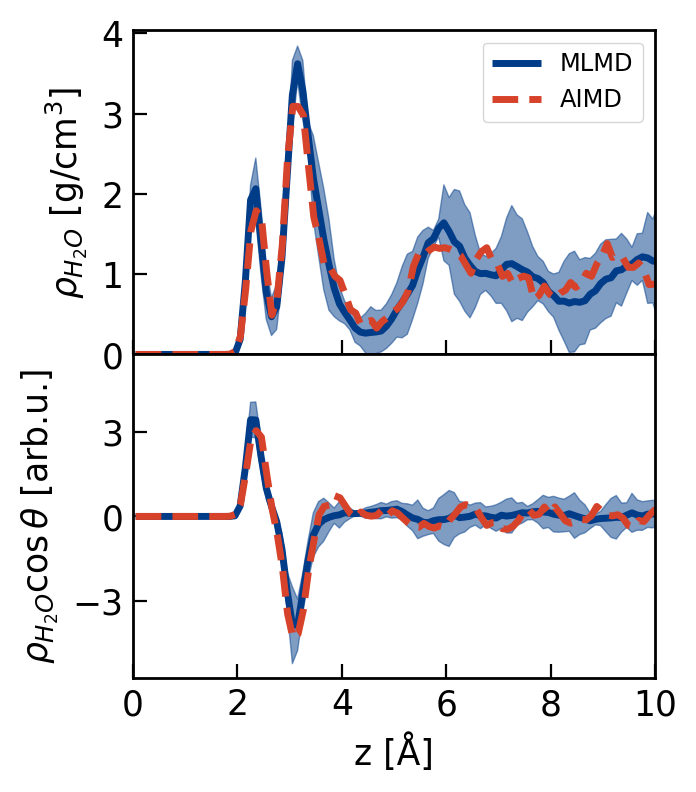

In [128]:
fig, axs = plt.subplots(2, 1, figsize=[3, 4], sharex=True)

ax = axs[0]

kw = "rho_water"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0)
mlmd_data_std = np.std(tmp_data, axis=0)

ax.plot(data[kw][0], mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    data[kw][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)
ax.plot(aimd_data[kw][0], aimd_data[kw][1], "--", label="AIMD", color="red")

ax.legend()
plot.ax_setlabel(ax, r"z [Å]", r"$\rho_{H_2O}$ [g/cm$^3$]")

ax.set_xlim(0.0, 10.0)
ax.set_ylim(bottom=0.0)
ax.set_yticks(np.arange(5))

ax = axs[1]

kw = "geo_dipole_water"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e3
mlmd_data_std = np.std(tmp_data, axis=0) * 1e3

ax.plot(data[kw][0], mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    data[kw][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)
ax.plot(aimd_data[kw][0], aimd_data[kw][1] * 1e3, "--", label="AIMD", color="red")

ax.set_xlim(0.0, 10.0)
ax.set_yticks(np.arange(-3, 5, 3))

plot.ax_setlabel(ax, r"z [Å]", r"$\rho_{H_2O}\cos\theta$ [arb.u.]")

fig.subplots_adjust(hspace=0.0)
fig.savefig("plot/rho_water.png")

plt.show()

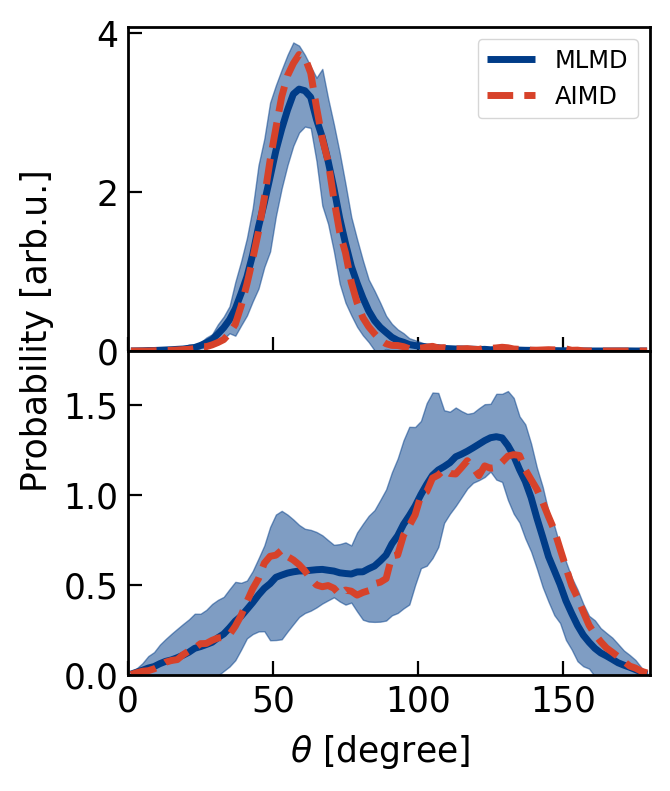

In [129]:
fig, axs = plt.subplots(2, 1, figsize=[3, 4], sharex=True)

ax = axs[0]

kw = "water_a_theta"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e2
mlmd_data_std = np.std(tmp_data, axis=0) * 1e2

ax.plot(data[kw][0], mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    data[kw][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)
ax.plot(aimd_data[kw][0], aimd_data[kw][1] * 1e2, "--", label="AIMD", color="red")

ax.legend()

ax.set_xlim(0.0, 180.0)
ax.set_ylim(bottom=0.0)

ax = axs[1]

kw = "water_b_theta"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e2
mlmd_data_std = np.std(tmp_data, axis=0) * 1e2

ax.plot(data[kw][0], mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    data[kw][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)
ax.plot(aimd_data[kw][0], aimd_data[kw][1] * 1e2, "--", label="AIMD", color="red")

ax.set_xlim(0.0, 180.0)
ax.set_ylim(0.0, 1.8)

# turn off scientific notation
ax.ticklabel_format(axis="x", style="plain")

fig.supxlabel(r"$\theta$ [degree]", y=-0.05, fontsize="small")
fig.supylabel("Probability [arb.u.]", x=-0.1, fontsize="small")

fig.subplots_adjust(hspace=0.0)
fig.savefig("plot/theta_water.png")

plt.show()

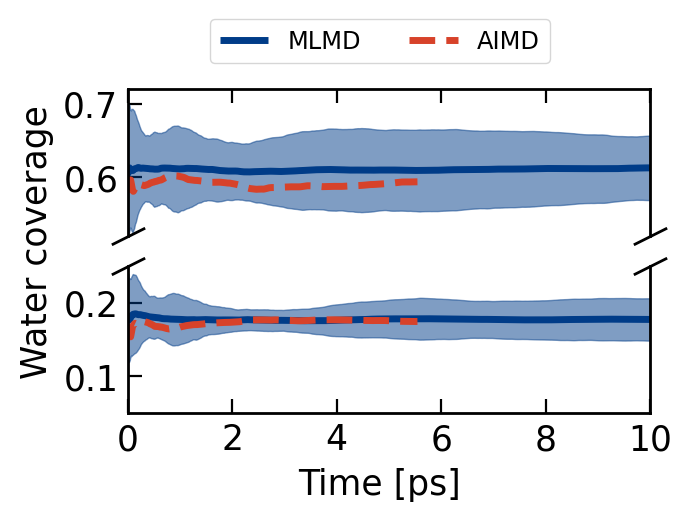

In [130]:
fig, axs = plt.subplots(2, 1, sharex=True)

ax = axs[0]

kw = "water_b_coverage"
tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(cumave(data[kw]))
mlmd_data_ave = np.mean(tmp_data, axis=0)
mlmd_data_std = np.std(tmp_data, axis=0)

x = np.arange(len(mlmd_data_ave)) * 0.5 * 1e-3
ax.plot(x, mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    x,
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

x = np.arange(len(aimd_data[kw])) * 0.5 * 1e-3
ax.plot(x, cumave(aimd_data[kw]), "--", label="AIMD", color="red")

ax.set_ylim(0.52, 0.72)

ax.ticklabel_format(axis="y", style="plain")

ax.spines.bottom.set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)

ax = axs[1]

kw = "water_a_coverage"
tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(cumave(data[kw]))
mlmd_data_ave = np.mean(tmp_data, axis=0)
mlmd_data_std = np.std(tmp_data, axis=0)

x = np.arange(len(mlmd_data_ave)) * 0.5 * 1e-3
ax.plot(x, mlmd_data_ave, color="blue")
ax.fill_between(
    x,
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

x = np.arange(len(aimd_data[kw])) * 0.5 * 1e-3
ax.plot(x, cumave(aimd_data[kw]), "--", color="red")

ax.set_xlim(0.0, 10.0)
ax.set_ylim(0.05, 0.25)

ax.ticklabel_format(axis="y", style="plain")

ax.spines.top.set_visible(False)
ax.xaxis.tick_bottom()

# ax.set_yticks(np.arange(0., 10, 2.5))
# ax.set_ylim(0, 9)

# fig.supxlabel(r"N$_\text{atom}$", y=-0.08)
# fig.supylabel(r"t / t$_\text{tot}$ [%]", x=-0.08)

# ax.legend(loc="right")

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)

lines = []
labels = []
for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    lines.extend(Line)
    labels.extend(Label)
fig.legend(lines, labels, ncols=3, loc="center", bbox_to_anchor=[0.5, 1.0])

fig.supxlabel("Time [ps]", y=-0.15, fontsize="small")
fig.supylabel("Water coverage", x=-0.1, fontsize="small")

fig.savefig("plot/water_coverage.png")

plt.show()

# hydrogen bond


In [4]:
prefix = "water_structure"
data = load_dict("data/%s.aimd_prl.pkl" % prefix)
n_water_a_aimd = (data["water_a_coverage"] * 36 * 2).mean()
n_water_b_aimd = (data["water_b_coverage"] * 36 * 2).mean()

n_water_a_mlmd = []
n_water_b_mlmd = []
fnames = glob.glob("data/%s.mlmd.*.pkl" % prefix)
fnames.sort()
for fname in fnames:
    data = load_dict(fname)
    n_water_a_mlmd.append((data["water_a_coverage"] * 36 * 2).mean())
    n_water_b_mlmd.append((data["water_b_coverage"] * 36 * 2).mean())
n_water_a_mlmd = np.mean(n_water_a_mlmd)
n_water_b_mlmd = np.mean(n_water_b_mlmd)

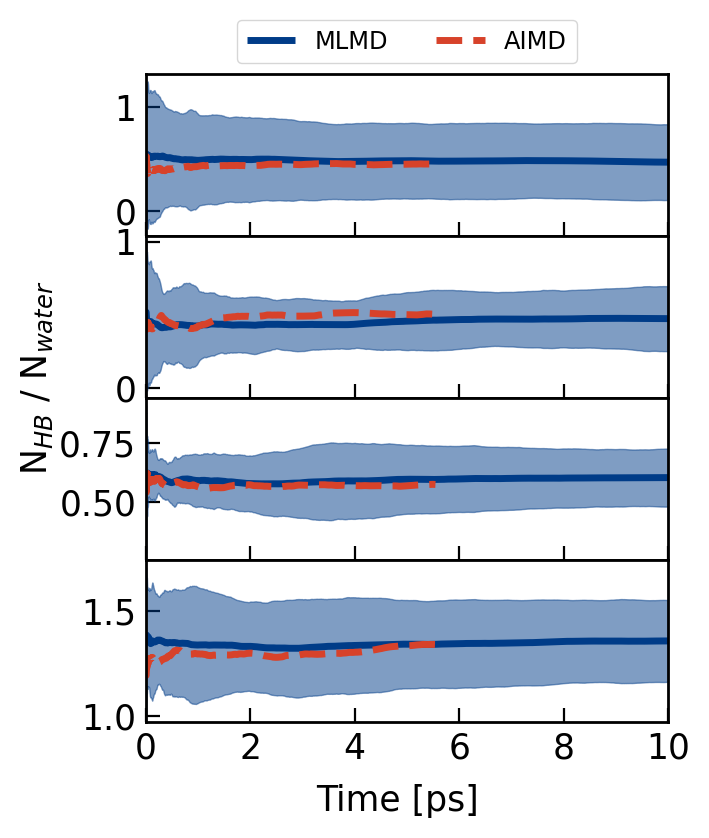

In [21]:
fig, axs = plt.subplots(4, 1, figsize=[3, 4], sharex=True)

ax = axs[0]
kw = "wata_d"

fnames = glob.glob("data/hb.mlmd.*.%s_count_by_time.npy" % kw)
fnames.sort()
tmp_data = []
for fname in fnames:
    mlmd_data = np.load(fname)
    tmp_data.append(mlmd_data[2])
mlmd_data_ave = np.mean(tmp_data, axis=0) / n_water_a_mlmd
mlmd_data_std = np.std(tmp_data, axis=0) / n_water_a_mlmd
ax.plot(mlmd_data[0] - mlmd_data[0][0], mlmd_data_ave, color="blue", label="MLMD")
ax.fill_between(
    mlmd_data[0] - mlmd_data[0][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

aimd_data = np.load("data/hb.aimd_prl.%s_count_by_time.npy" % kw)
ax.plot(
    aimd_data[0] - aimd_data[0][0], aimd_data[2] / n_water_a_aimd, "--", color="red", label="AIMD",
)

ax.ticklabel_format(axis="y", style="plain")
ax.legend(ncols=2, loc="center", bbox_to_anchor=[0.5, 1.2])

ax = axs[1]
kw = "wata_a"

fnames = glob.glob("data/hb.mlmd.*.%s_count_by_time.npy" % kw)
fnames.sort()
tmp_data = []
for fname in fnames:
    mlmd_data = np.load(fname)
    tmp_data.append(mlmd_data[2])
mlmd_data_ave = np.mean(tmp_data, axis=0) / n_water_a_mlmd
mlmd_data_std = np.std(tmp_data, axis=0) / n_water_a_mlmd
ax.plot(mlmd_data[0] - mlmd_data[0][0], mlmd_data_ave, color="blue")
ax.fill_between(
    mlmd_data[0] - mlmd_data[0][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

aimd_data = np.load("data/hb.aimd_prl.%s_count_by_time.npy" % kw)
ax.plot(
    aimd_data[0] - aimd_data[0][0], aimd_data[2] / n_water_a_aimd, "--", color="red"
)

ax.ticklabel_format(axis="y", style="plain")

ax = axs[2]
kw = "watb_d"

fnames = glob.glob("data/hb.mlmd.*.%s_count_by_time.npy" % kw)
fnames.sort()
tmp_data = []
for fname in fnames:
    mlmd_data = np.load(fname)
    tmp_data.append(mlmd_data[2])
mlmd_data_ave = np.mean(tmp_data, axis=0) / n_water_b_mlmd
mlmd_data_std = np.std(tmp_data, axis=0) / n_water_b_mlmd
ax.plot(mlmd_data[0] - mlmd_data[0][0], mlmd_data_ave, color="blue")
ax.fill_between(
    mlmd_data[0] - mlmd_data[0][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

aimd_data = np.load("data/hb.aimd_prl.%s_count_by_time.npy" % kw)
ax.plot(
    aimd_data[0] - aimd_data[0][0], aimd_data[2] / n_water_b_aimd, "--", color="red"
)

ax.ticklabel_format(axis="y", style="plain")

ax = axs[3]
kw = "watb_a"

fnames = glob.glob("data/hb.mlmd.*.%s_count_by_time.npy" % kw)
fnames.sort()
tmp_data = []
for fname in fnames:
    mlmd_data = np.load(fname)
    tmp_data.append(mlmd_data[2])
mlmd_data_ave = np.mean(tmp_data, axis=0) / n_water_b_mlmd
mlmd_data_std = np.std(tmp_data, axis=0) / n_water_b_mlmd
ax.plot(mlmd_data[0] - mlmd_data[0][0], mlmd_data_ave, color="blue")
ax.fill_between(
    mlmd_data[0] - mlmd_data[0][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

aimd_data = np.load("data/hb.aimd_prl.%s_count_by_time.npy" % kw)
ax.plot(
    aimd_data[0] - aimd_data[0][0], aimd_data[2] / n_water_b_aimd, "--", color="red"
)

ax.ticklabel_format(axis="y", style="plain")

ax.set_xlim(0.0, 10.0)

fig.supxlabel("Time [ps]", y=-0.05, fontsize="small")
fig.supylabel(r"N$_{HB}$ / N$_{water}$", x=-0.13, fontsize="small")

fig.subplots_adjust(hspace=0.0)
fig.savefig("plot/water_hb.png")

plt.show()

# survival probability


In [23]:
prefix = "water_sp"
aimd_data = load_dict("data/%s.aimd_prl.pkl" % prefix)
mlmd_all_data = []
fnames = glob.glob("data/%s.mlmd.*.pkl" % prefix)
fnames.sort()
for fname in fnames:
    mlmd_all_data.append(load_dict(fname))

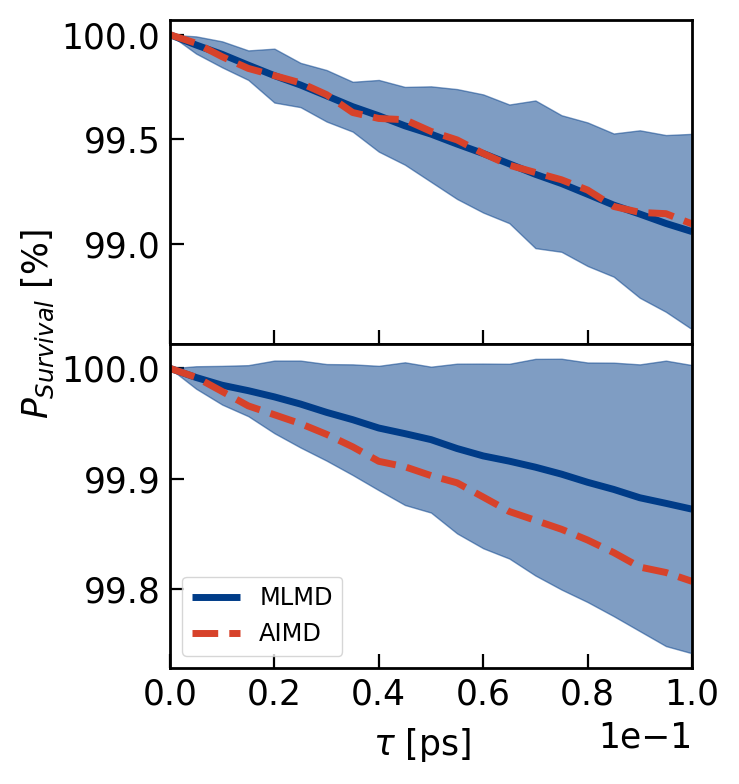

In [25]:
fig, axs = plt.subplots(2, 1, figsize=[3, 4], sharex=True)

# timestep [ps]
ts = 0.5 * 10 * 1e-3

ax = axs[0]
kw = "water_a"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e2
mlmd_data_std = np.std(tmp_data, axis=0) * 1e2

x = ts * data[kw][0]
ax.plot(x, mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    x,
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

ax.plot(ts * aimd_data[kw][0], aimd_data[kw][1] * 1e2, "--", label="AIMD", color="red")

ax.ticklabel_format(axis="y", style="plain")

ax = axs[1]
kw = "water_a_and_b"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e2
mlmd_data_std = np.std(tmp_data, axis=0) * 1e2

x = ts * data[kw][0]
ax.plot(x, mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    x,
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

ax.plot(ts * aimd_data[kw][0], aimd_data[kw][1] * 1e2, "--", label="AIMD", color="red")
ax.legend(loc="lower left")

ax.set_xlim(0.0, 0.1)
ax.ticklabel_format(axis="y", style="plain")

fig.supxlabel(r"$\tau$ [ps]", y=-0.05, fontsize="small")
fig.supylabel(r"$P_{Survival}$ [%]", x=-0.17, fontsize="small")

fig.subplots_adjust(hspace=0.0)

fig.savefig("plot/water_sp.png")

plt.show()